In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from scipy.stats import gaussian_kde
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d
import re
import utility
from utility import plots_dir

/ru-auth/local/home/risc_soft/miniconda3/envs/meso_wlc/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/lustre/fs4/risc_lab/scratch/risc_soft/miniconda3/envs/meso_wlc/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import PolynomialFeatures

#### Global Variables

In [4]:
torch.manual_seed(68)
plots_dir = plots_dir
zenodo_data_path = '/ru-auth/local/home/abrenner/mystore/meso_wlc_manuscript_data/'
rydberg_data = zenodo_data_path + 'atac_ricc_data/ricc_data/rydberg_data/'
data_dir = zenodo_data_path + 'intermed_data/flds/nrls_165_to_215/'
model_path = zenodo_data_path + 'cnns/'

#### Functions

In [5]:
def nearest_neighbor_smooth(array, halfwidth = 5):
    """
    Perform smoothing over halfwidth*2 nearest neighbors for 1D or 2D NumPy arrays.
    
    Parameters:
    - array: Input 1D or 2D NumPy array.
    
    Returns:
    - A NumPy array with smoothing applied over 10 nearest neighbors.
      For 1D arrays, the smoothing is applied over the array.
      For 2D arrays, the smoothing is applied across each row.
    """
    if array.ndim == 1:
        # Treat the array as a 1D array.
        smoothed_array = np.zeros_like(array, dtype=float)
        neighbors_on_each_side = halfwidth
        
        for i in range(array.shape[0]):
            start_index = max(0, i - neighbors_on_each_side + 1)
            end_index = min(array.shape[0], i + neighbors_on_each_side)
            neighbors = array[start_index:end_index]
            smoothed_array[i] = np.mean(neighbors)
            
    elif array.ndim == 2:
        # The original processing for 2D arrays.
        smoothed_array = np.zeros_like(array, dtype=float)
        neighbors_on_each_side = halfwidth
        
        for i in range(array.shape[0]):
            for j in range(array.shape[1]):
                start_index = max(0, j - neighbors_on_each_side + 1)
                end_index = min(array.shape[1], j + neighbors_on_each_side)
                neighbors = array[i, start_index:end_index]
                smoothed_array[i, j] = np.mean(neighbors)
    else:
        raise ValueError("Input array must be either 1D or 2D.")
    
    return smoothed_array

def load_all_trials(nrl):
    var_nrl_dir = data_dir
    flds_given_nrl = np.load(var_nrl_dir+'flds_mean_tot_'+str(nrl)+'_nrl_12nucs_2kbt.npy')[0]
    flds_given_nrl = np.log2(flds_given_nrl / np.max(flds_given_nrl))
    return flds_given_nrl

def knn_smoothing(data, k=10):
    n = len(data)
    smoothed_data = np.zeros(n)
    
    for i in range(n):
        # Determine the start and end indices for the neighborhood
        start = max(0, i - k // 2)
        end = min(n, i + k // 2 + 1)
        
        # Compute the mean of the neighborhood
        smoothed_data[i] = np.mean(data[start:end])
    
    return smoothed_data

def read_csv_to_numpy(filename, skip_header=1):
    # Load the CSV file as a NumPy array
    data = np.genfromtxt(filename, delimiter=',', skip_header=skip_header, dtype='float64')  # Adjust 'skip_header' as needed
    return data

# Functions
def NormalNorm(arr, Clip = None):
    arr = np.asarray(arr)
    mu = arr.mean(axis = 0, keepdims = True)
    sig = arr.std(axis = 0, keepdims = True)
    arr = (arr - mu)/sig
    if(Clip != None):
        arr[arr < -Clip] = -Clip
        arr[arr > Clip] = Clip
    arr[np.isnan(arr)] = 0
    return(arr, np.squeeze(mu), np.squeeze(sig))

def max_normalize_rows(array):
    """
    Max-normalize each row of a 2D NumPy array.
    
    Parameters:
    - array: Input 2D NumPy array.
    
    Returns:
    - A 2D NumPy array with each row max-normalized.
    """
    # Find the maximum value in each row
    row_maxes = np.max(array, axis=1).reshape(-1, 1)  # Reshape for broadcasting
    # Divide each row by its maximum value
    normalized_array = array / row_maxes
    return normalized_array

def r_squared(y_true, y_pred):
    """
    Compute R^2 score.
    
    Parameters:
    - y_true: Actual values (tensor).
    - y_pred: Predicted values (tensor).
    
    Returns:
    - R^2 score.
    """
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def get_rmse(y_true, y_pred):
    """
    Compute RMSE from pytorch tensors
    
    Parameters:
    - y_true: Actual values (tensor).
    - y_pred: Predicted values (tensor).
    
    Returns:
    - Root mean square error
    """
    mse = torch.mean((y_true - y_pred) ** 2)
    rmse = torch.sqrt(mse)
    return rmse


In [6]:

temp_nrls = [i for i in range(165,216)]

num_trls = 15
trls = np.arange(1,num_trls + 1)
trials = [str(i)+'_trial/wlcsim/data/' for i in trls]
timePts = 300
eq = 10 

tot_index = 0
array_size = len(trials) * (timePts - eq + 1) * len(temp_nrls)
targets_nrl = np.zeros((array_size, 2))
features_nrl = np.zeros((array_size, 451))
# fld_data_pre = np.zeros((len(exp_list, len(trials), timePts - eq + 1, 451))
for n, exp in enumerate(temp_nrls):
    fld_data_pre = np.zeros((len(trials), timePts - eq + 1, 451))    
    for idx, t in enumerate(trials):
#         print(n)
        trial_label = re.search("^.*?\/", t)[0][:-1] 
#         exp_label = exp[:-1] # Make this dynamic 
        fld = np.load(data_dir + 'flds_'+str(exp)+'_nrl_12nucs_2kbt_'+str(idx+1)+'_trial.npy')#, fld_data_per_trial)
#         fld_data_per_trial = np.log2(fld/np.sum(fld))
        fld_data_per_trial = fld/np.sum(fld) # Not using log 2
        for snap in np.arange(0,timePts - eq + 1):
            features_nrl[tot_index] = fld_data_per_trial[snap]
            targets_nrl[tot_index, 0] = 127
            # nrl
            targets_nrl[tot_index, 1] = exp
            tot_index += 1

In [7]:
nrl_sim_features = features_nrl
nrl_sim_targets = targets_nrl[:, 1]
nrl_sim_features = nrl_sim_features/np.sum(nrl_sim_features, axis = 1, keepdims = True)
nrl_sim_features = max_normalize_rows(nrl_sim_features)


# This takes the target NRLs (which range from 165 to 215)
# And normalizes them so the middle one (190) is 0
# 190 is the sim_targets_mean and is save for later transformation of predicted results
nrl_sim_targets_norm, sim_targets_mean, nrl_sim_targets_std = NormalNorm(nrl_sim_targets)

In [8]:
X = nrl_sim_features[:, :, None]
y = nrl_sim_targets_norm[:, None]

print(np.shape(X))
print(np.shape(y))

(222615, 451, 1)
(222615, 1)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)
print(np.shape(X_train))
print(np.shape(y_train))

(149152, 451, 1)
(149152, 1)


In [10]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_train_tensor = X_train_tensor.permute(0, 2, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_test_tensor = X_test_tensor.permute(0, 2, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [11]:
# np.shape(X_train_tensor)

Define the model

In [12]:
# Create a Dataset and DataLoader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
# Define the 1D CNN model
kernel_sz = 10
dil_sz = 5
class CNN1DRegression(nn.Module):
    def __init__(self):
        super(CNN1DRegression, self).__init__()
        # In_channels = 1 makes this a 1D CNN
        neurons = 64
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=neurons, kernel_size=kernel_sz, dilation = dil_sz, stride=1, padding=1)
        self.dropout = nn.Dropout(p=0.2)
        # self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=neurons, out_channels=2*neurons, kernel_size=kernel_sz, dilation = dil_sz, stride=1, padding=1)
        self.fc1 = nn.Linear(10240 , 128)  # Adjust 1st dim  size according to your pooling and conv layers
        self.fc2 = nn.Linear(128, 1) # Predicting one output

    def forward(self, x):
        x = self.pool(torch.nn.functional.leaky_relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.nn.functional.leaky_relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [14]:
# model = CNN1DRegression()

# # Loss and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# loss_by_epoch = []
# # Train the model
# epchs = 10
# for epoch in range(epchs):  # Loop over the dataset multiple times
#     running_loss = 0.0
#     for inputs, labels in dataloader:
#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')
#     loss_by_epoch.append(running_loss/len(dataloader))

# print('Finished Training')

In [16]:
# torch.save(model, model_path+'model_nrl_only.pth')
# np.save(model_path+'model_nrl_only_loss.npy', loss_by_epoch)
model = torch.load( model_path+'model_nrl_only.pth')

In [17]:
# Set the model to evaluation mode
model.eval()

with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions = model(X_train_tensor)
    predictions_test = model(X_test_tensor)

In [18]:
r2_score_test = r_squared(y_test_tensor, predictions_test)
r2_score_test

tensor(0.9935)

In [19]:
# rmse = get_rmse(y_test_tensor, predictions_test)
rmse = get_rmse(y_test_tensor*nrl_sim_targets_std + sim_targets_mean, predictions_test*nrl_sim_targets_std + sim_targets_mean)
rmse

tensor(1.1884)

In [20]:
# Data preparation
actual_nrls = np.array(y_test_tensor).flatten() * nrl_sim_targets_std + sim_targets_mean
predicted_nrls = np.array(predictions_test).flatten() * nrl_sim_targets_std + sim_targets_mean

# Calculate the point density
xy = np.vstack([actual_nrls, predicted_nrls])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
actual_nrls, predicted_nrls, z = actual_nrls[idx], predicted_nrls[idx], z[idx]

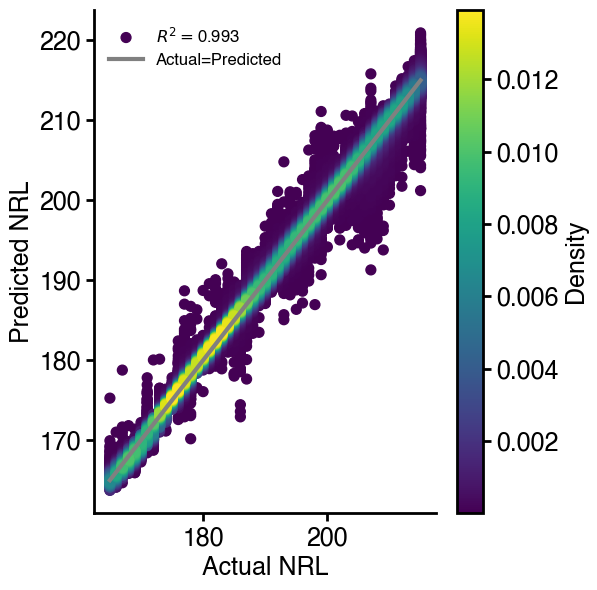

In [21]:
# Setup the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

# Density Plot
scatter = ax.scatter(actual_nrls, predicted_nrls, c=z, s=50, cmap='viridis', 
                     label="$R^2=$"+str(np.round(np.array(r2_score_test), 3)), rasterized = True
                    )

# Line for actual = predicted
x_eq_y_line = np.linspace(165, 215, 400)
ax.plot(x_eq_y_line, x_eq_y_line, color='gray', label='Actual=Predicted')

# Labels and customization
ax.set_xlabel('Actual NRL')
ax.set_ylabel('Predicted NRL')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.colorbar(scatter, ax=ax, label='Density')
plt.legend(frameon=False, fontsize=12, loc='upper left')
plt.tight_layout()
# plt.savefig(plots_dir+'effect_nrl/nrl_1cnn_regression.pdf')
plt.show()

# Predict experimental Data

In [22]:
data_dir_ricc_atac = zenodo_data_path + 'atac_ricc_data/ricc_data/'
# filenames = os.listdir(data_dir_ricc_atac+"*mat")
start_series = 50
ricc_atac1 = np.array(pd.read_csv(data_dir_ricc_atac + 'DHCCARmerged300_BJatacPooledNarrowPeaksAbQ2Mrg.subtexc.gc.isdmat'))[start_series:start_series+450]
ricc_atac2 = np.array(pd.read_csv(data_dir_ricc_atac + 'BJ5TAmerged300_BJatacPooledNarrowPeaksAbQ2Mrg.subtexc.gc.isdmat'))[start_series:start_series+450]

In [23]:
whole_genome_data_fp = zenodo_data_path + 'atac_ricc_data/ricc_data/nolimit_hist_data_nodups_DHCCARmerged34.log'
# Read the data from the log file into a DataFrame
df = pd.read_csv(whole_genome_data_fp, sep='\t', comment='#', skiprows=10)

In [24]:
frag_len = np.array(df[(df.insert_size >= 50) & (df.insert_size <= 500)]['insert_size'])
counts = np.array(df[(df.insert_size >= 50) & (df.insert_size <= 500)]['All_Reads.fr_count'])
norm_counts = counts/np.max(counts)
# plt.plot(frag_len, np.log2(norm_counts))

In [25]:
smoothed_atac1_corr = ricc_atac1 # ricc1_smooth.reshape(-1,1) # nearest_neighbor_smooth(ricc_atac1)
atac1_reformat_pre = smoothed_atac1_corr/np.max(smoothed_atac1_corr)
atac1_reformat = atac1_reformat_pre[:,:,None]
atac1_corr_tensor = torch.tensor(atac1_reformat, dtype=torch.float32)
atac1_corr_tensor = atac1_corr_tensor.permute(1, 2, 0)

with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_atac1_corr= model(atac1_corr_tensor)

atac1_pred_nrl = int((predictions_atac1_corr*nrl_sim_targets_std+sim_targets_mean).round().item())
atac1_pred_nrl

182

In [26]:
smoothed_atac2_corr = ricc_atac2 
atac2_reformat_pre = smoothed_atac2_corr/np.max(smoothed_atac2_corr)
atac2_reformat = atac2_reformat_pre[:,:,None]
atac2_corr_tensor = torch.tensor(atac2_reformat, dtype=torch.float32)
atac2_corr_tensor = atac2_corr_tensor.permute(1, 2, 0)

with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_atac2_corr= model(atac2_corr_tensor)

atac2_pred_nrl = int((predictions_atac2_corr*nrl_sim_targets_std+sim_targets_mean).round().item())
atac2_pred_nrl

186

#### Rydberg Data -- Rad Gel

Rydberg B, Holley WR, Mian IS, Chatterjee A. Chromatin conformation in living cells: support for a zig-zag model of the 30 nm chromatin fiber. J Mol Biol. 1998 Nov 20;284(1):71-84. doi: 10.1006/jmbi.1998.2150. PMID: 9811543.
Data was extracted using WebPlotDigitizer

In [25]:
data_peak1 = read_csv_to_numpy(rydberg_data+'figure5_first_peak_data.csv')[:-1]
data_peak2_5 = read_csv_to_numpy(rydberg_data+'figure4_200gy.csv')
data_points = np.concatenate((data_peak1, data_peak2_5), axis=0)

# Create a linear interpolation model
interpolator = interp1d(data_points[:, 0], data_points[:, 1], kind='linear', fill_value='extrapolate')

# Define the range for interpolation, adjusted for the new conditions
min_frag = 50
max_frag = 500
x_new = np.arange(max(min_frag, np.floor(data_points[0, 0])), min(max_frag, np.ceil(data_points[-1, 0])))

# Perform the interpolation
y_new = interpolator(x_new)

# Resulting interpolated values
interpolated_data = np.column_stack((x_new, y_new))
# print(interpolated_data)

In [26]:
rydberg_cho = y_new.reshape(-1,1) # nearest_neighbor_smooth(ricc_rydberg_cho)
rydberg_cho_reformat_pre = rydberg_cho/np.max(rydberg_cho)
rydberg_cho_reformat = rydberg_cho_reformat_pre[:,:,None]
rydberg_cho_tensor = torch.tensor(rydberg_cho_reformat, dtype=torch.float32)
rydberg_cho_tensor1 = rydberg_cho_tensor.permute(1, 2, 0)

# Set the model to evaluation mode
model.eval()


with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_rydberg_cho= model(rydberg_cho_tensor1)

rydberg_cho_pred_nrl = int((predictions_rydberg_cho*nrl_sim_targets_std+sim_targets_mean).round().item())
rydberg_cho_pred_nrl

176

In [27]:
fibroblast_data = read_csv_to_numpy(rydberg_data+'figure2_80gy.csv', skip_header=0)

In [28]:
# Create a linear interpolation model
interpolator = interp1d(fibroblast_data[:, 0], fibroblast_data[:, 1], kind='linear', fill_value='extrapolate')

# Define the range for interpolation, adjusted for the new conditions
min_frag = 50
max_frag = 500
x_fibro = np.arange(max(min_frag, np.floor(fibroblast_data[0, 0])), min(max_frag, np.ceil(fibroblast_data[-1, 0])))

# Perform the interpolation
y_fibro = interpolator(x_fibro)

# Resulting interpolated values
interpolated_fibro = np.column_stack((x_fibro, y_fibro))
# print(interpolated_data)

In [29]:
rydberg_fibro = y_fibro .reshape(-1,1) # nearest_neighbor_smooth(ricc_rydberg_fibro)
rydberg_fibro_reformat_pre = rydberg_fibro/np.max(rydberg_fibro)
rydberg_fibro_reformat = rydberg_fibro_reformat_pre[:,:,None]
rydberg_fibro_tensor = torch.tensor(rydberg_fibro_reformat, dtype=torch.float32)
rydberg_fibro_tensor1 = rydberg_fibro_tensor.permute(1, 2, 0)

# Set the model to evaluation mode
model.eval()


with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_rydberg_fibro= model(rydberg_fibro_tensor1)

rydberg_fibro_pred_nrl = int((predictions_rydberg_fibro*nrl_sim_targets_std+sim_targets_mean).round().item())
rydberg_fibro_pred_nrl

178

# Make composite graphs

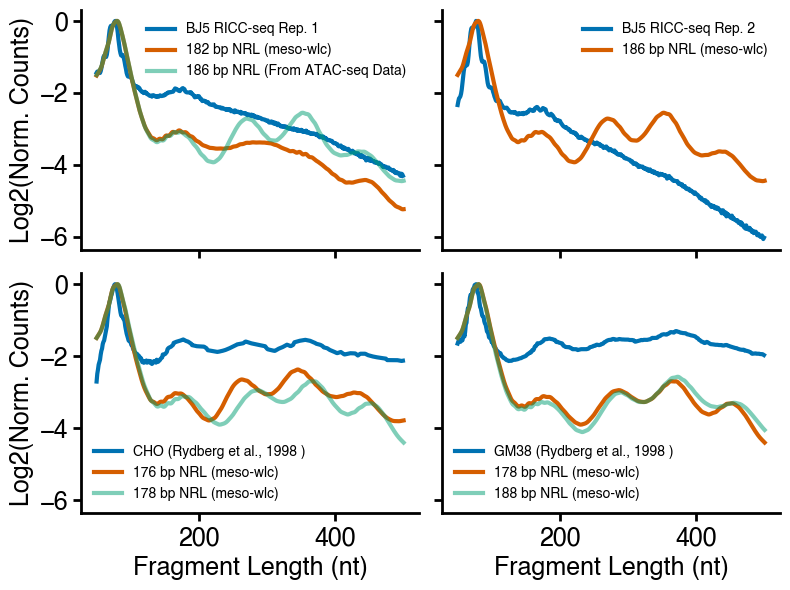

In [30]:
fix, axs = plt.subplots(2,2, figsize = (8,6), sharey = True, sharex = True)

# Panel 1
xs = np.arange(50,501)
axs[0, 0].plot(xs[:-1], np.log2(atac1_reformat_pre), label = 'BJ5 RICC-seq Rep. 1')
# axs[0].plot(np.log2(atac2_reformat_pre), label = 'BJ5 Rep 2')
# axs.plot(np.log2(ricc_atac1/np.max(ricc_atac1)), label = 'BJ5 RICC-Seq w/ ATAC')
# axs[1].plot(np.log2(chick_reformat[2]), label = 'exp3')
nrl = 182
cnn_nrl_fld = load_all_trials(nrl)
axs[0, 0].plot(xs, cnn_nrl_fld, label = str(nrl)+' bp NRL (meso-wlc)')
nrl = 186
atac_nrl = load_all_trials(nrl)
axs[0,0].plot(xs, atac_nrl, label = str(nrl)+' bp NRL (From ATAC-seq Data)', alpha = 0.5)

# Panel 2
axs[0, 1].plot(xs[:-1], np.log2(atac2_reformat_pre), label = 'BJ5 RICC-seq Rep. 2')
# axs.plot(np.log2(ricc_atac1/np.max(ricc_atac1)), label = 'BJ5 RICC-Seq w/ ATAC')
# axs[1].plot(np.log2(chick_reformat[2]), label = 'exp3')
nrl = 186
cnn_nrl_fld = load_all_trials(nrl)
axs[0, 1].plot(xs, cnn_nrl_fld, label = str(nrl)+' bp NRL (meso-wlc)')
# nrl = 186
# atac_nrl = load_all_trials(nrl)
# axs[1].plot(atac_nrl, label = str(nrl)+' bp NRL (From ATAC-seq Data)')

# Panel 3
axs[1, 0].plot(xs[:-1], np.log2(y_new/np.max(y_new)), label = 'CHO (Rydberg et al., 1998 )')
nrl = 176
cnn_nrl_fld = load_all_trials(nrl)
axs[1, 0].plot(xs, cnn_nrl_fld, label = str(nrl)+' bp NRL (meso-wlc)')
nrl = 178
cnn_nrl_fld = load_all_trials(nrl)
axs[1, 0].plot(xs, cnn_nrl_fld, label = str(nrl)+' bp NRL (meso-wlc)', alpha = 0.5)

# Panel 3
axs[1, 1].plot(xs[:-1], np.log2(y_fibro/np.max(y_fibro)), label = 'GM38 (Rydberg et al., 1998 )')
nrl = 178
cnn_nrl_fld = load_all_trials(nrl)
axs[1, 1].plot(xs, cnn_nrl_fld, label = str(nrl)+' bp NRL (meso-wlc)')
nrl = 188
cnn_nrl_fld = load_all_trials(nrl)
axs[1, 1].plot(xs, cnn_nrl_fld, label = str(nrl)+' bp NRL (meso-wlc)', alpha = .5)

# idx_to_plot = 20
# axs[1].plot(np.log2(nrl_sim_features[idx_to_plot*(15*291)]), label = 'nrl='+str(int(nrl_sim_targets[idx_to_plot*(15*291)])))
# idx_to_plot = 28
# axs[1].plot(np.log2(nrl_sim_features[idx_to_plot*(15*291)]), label = 'nrl='+str(int(nrl_sim_targets[idx_to_plot*(15*291)])))
axs[0, 0].legend(frameon = False)
axs[0, 1].legend(frameon = False)
axs[1, 0].legend(frameon = False)
axs[1, 1].legend(frameon = False)
axs[0, 0].set_ylabel('Log2(Norm. Counts)')
axs[1, 0].set_ylabel('Log2(Norm. Counts)')
axs[1, 0].set_xlabel('Fragment Length (nt)')
axs[1, 1].set_xlabel('Fragment Length (nt)')
# Get rid of top and right borders
[axs[idx, idx2].spines[desc].set_visible(False) for idx in range(0,2) for idx2 in range(0,2) for desc in ['top', 'right']]
plt.tight_layout()#pad = 4)
# plt.savefig(plots_dir+'predict_experimental_nrl_ricc_atac_rydberg.pdf')
plt.show()

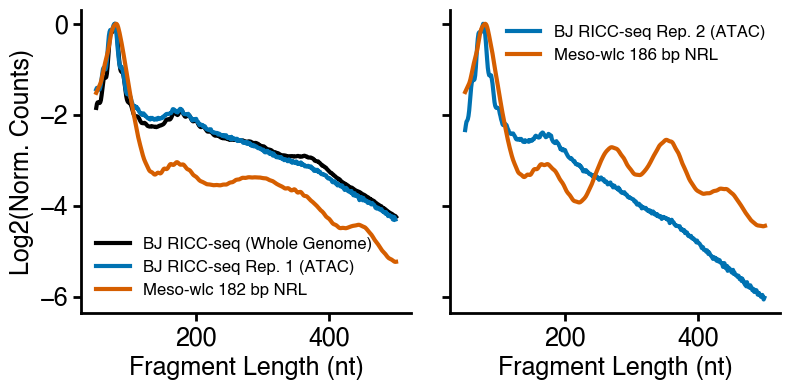

In [31]:
fix, axs = plt.subplots(1,2, figsize = (8,4), sharey = True, sharex = True)

# Panel 1
nrl = 182
cnn_nrl_fld = load_all_trials(nrl)
axs[0].plot(frag_len, np.log2(norm_counts), label = 'BJ RICC-seq (Whole Genome)', color = 'black')
xs = np.arange(50,501)
axs[0].plot(xs[:-1], np.log2(atac1_reformat_pre), label = 'BJ RICC-seq Rep. 1 (ATAC)')
axs[0].plot(xs, cnn_nrl_fld, label = 'Meso-wlc ' + str(nrl)+' bp NRL')
# nrl = 186
# atac_nrl = load_all_trials(nrl)
# axs[0].plot(xs, atac_nrl, label = str(nrl)+' bp NRL (From ATAC-seq Data)', alpha = 0.5)

# Panel 2
axs[1].plot(xs[:-1], np.log2(atac2_reformat_pre), label = 'BJ RICC-seq Rep. 2 (ATAC)')
# axs.plot(np.log2(ricc_atac1/np.max(ricc_atac1)), label = 'BJ5 RICC-Seq w/ ATAC')
# axs[1].plot(np.log2(chick_reformat[2]), label = 'exp3')
nrl = 186
cnn_nrl_fld = load_all_trials(nrl)
axs[1].plot(xs, cnn_nrl_fld, label = 'Meso-wlc ' + str(nrl)+' bp NRL')
# nrl = 186
# atac_nrl = load_all_trials(nrl)
# axs[1].plot(atac_nrl, label = str(nrl)+' bp NRL (From ATAC-seq Data)')
axs[0].legend(frameon = False, fontsize = "12")
axs[1].legend(frameon = False, fontsize = "12")
axs[0].set_ylabel('Log2(Norm. Counts)')
axs[0].set_ylabel('Log2(Norm. Counts)')
axs[0].set_xlabel('Fragment Length (nt)')
axs[1].set_xlabel('Fragment Length (nt)')
# Get rid of top and right borders
[axs[idx].spines[desc].set_visible(False) for idx in range(0,2) for desc in ['top', 'right']]
plt.tight_layout()#pad = 4)
# plt.savefig(plots_dir+'predict_ricc_bj.pdf')
plt.show()

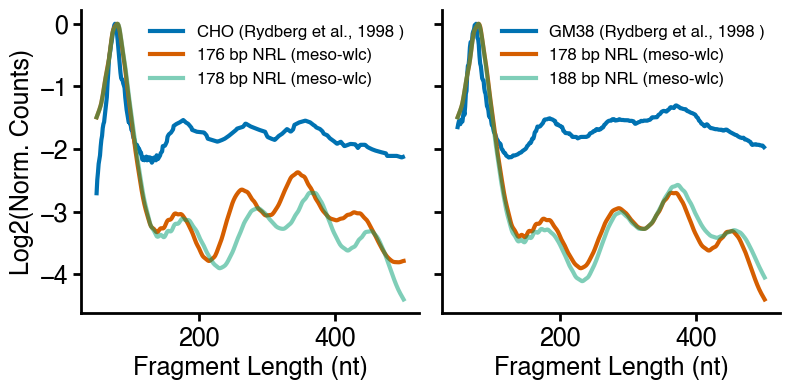

In [32]:
fix, axs = plt.subplots(1,2, figsize = (8,4), sharey = True, sharex = True)
# Panel 3
axs[0].plot(xs[:-1], np.log2(y_new/np.max(y_new)), label = 'CHO (Rydberg et al., 1998 )')
nrl = 176
cnn_nrl_fld = load_all_trials(nrl)
axs[0].plot(xs, cnn_nrl_fld, label = str(nrl)+' bp NRL (meso-wlc)')
nrl = 178
cnn_nrl_fld = load_all_trials(nrl)
axs[0].plot(xs, cnn_nrl_fld, label = str(nrl)+' bp NRL (meso-wlc)', alpha = 0.5)

# Panel 3
axs[1].plot(xs[:-1], np.log2(y_fibro/np.max(y_fibro)), label = 'GM38 (Rydberg et al., 1998 )')
nrl = 178
cnn_nrl_fld = load_all_trials(nrl)
axs[1].plot(xs, cnn_nrl_fld, label = str(nrl)+' bp NRL (meso-wlc)')
nrl = 188
cnn_nrl_fld = load_all_trials(nrl)
axs[1].plot(xs, cnn_nrl_fld, label = str(nrl)+' bp NRL (meso-wlc)', alpha = .5)

# idx_to_plot = 20
# axs[1].plot(np.log2(nrl_sim_features[idx_to_plot*(15*291)]), label = 'nrl='+str(int(nrl_sim_targets[idx_to_plot*(15*291)])))
# idx_to_plot = 28
# axs[1].plot(np.log2(nrl_sim_features[idx_to_plot*(15*291)]), label = 'nrl='+str(int(nrl_sim_targets[idx_to_plot*(15*291)])))
axs[0].legend(frameon = False, fontsize = "12")
axs[1].legend(frameon = False, fontsize = "12")
axs[0].set_ylabel('Log2(Norm. Counts)')
axs[0].set_ylabel('Log2(Norm. Counts)')
axs[0].set_xlabel('Fragment Length (nt)')
axs[1].set_xlabel('Fragment Length (nt)')
# Get rid of top and right borders
[axs[idx].spines[desc].set_visible(False) for idx in range(0,2) for desc in ['top', 'right']]
plt.tight_layout()#pad = 4)
# plt.savefig(plots_dir+'predict_rydberg.pdf')
plt.show()

# Apply 1D-CNN to RICC 2.0 Data

In [35]:
conv_net_folder = '/ru-auth/local/home/abrenner/myscratch/conv_net/'
data_folder = conv_net_folder + 'data/'
nrl_chicken = np.squeeze(np.load(data_folder + 'chicken_data.npy', allow_pickle=True)).reshape([3,451])
# nrl_k562 = np.squeeze(np.load(data_folder + 'k562_data.npy', allow_pickle=True))

In [57]:
nrl_chicken = nrl_chicken/np.sum(nrl_chicken, axis = 1, keepdims = True)
smoothed_chicken = nearest_neighbor_smooth(nrl_chicken, halfwidth = 5)
chick_reformat_smooth = max_normalize_rows(smoothed_chicken)[:,:,None]
chicken_tensor = torch.tensor(chick_reformat_smooth, dtype=torch.float32)
chicken_tensor = chicken_tensor.permute(0, 2, 1)

with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_chicken_smooth = model(chicken_tensor)

chicken_predictions_smooth = np.array(predictions_chicken_smooth*nrl_sim_targets_std+sim_targets_mean)
chicken_predictions_smooth

array([[194.12695],
       [191.90596],
       [194.40285]], dtype=float32)

In [37]:
nrl_chicken = np.squeeze(np.load(data_folder + 'chicken_data.npy', allow_pickle=True)).reshape([3,451])
nrl_chicken = nrl_chicken/np.sum(nrl_chicken, axis = 1, keepdims = True)
chick_reformat = max_normalize_rows(nrl_chicken)[:,:,None]
chicken_tensor = torch.tensor(chick_reformat, dtype=torch.float32)
chicken_tensor = chicken_tensor.permute(0, 2, 1)

with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_chicken = model(chicken_tensor)

chicken_predictions = np.array(predictions_chicken*nrl_sim_targets_std+sim_targets_mean)
chicken_predictions

array([[200.3652 ],
       [195.84486],
       [201.0819 ]], dtype=float32)

In [354]:
int(np.round(np.array(chicken_predictions)[0][0]))

194

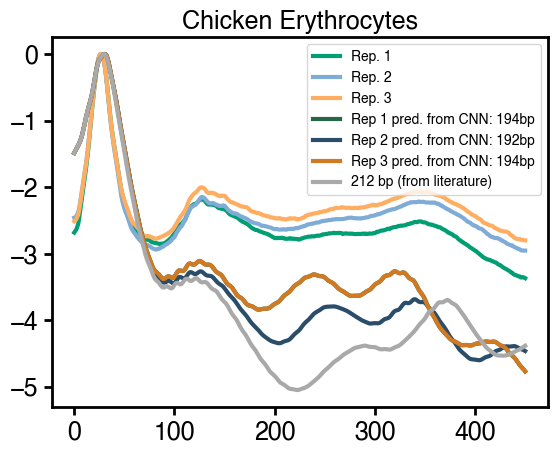

In [355]:
plt.title("Chicken Erythrocytes")
plt.plot(np.log2(chick_reformat[0]), label = 'Rep. 1', color ='#009E73')
plt.plot(np.log2(chick_reformat[1]), label = 'Rep. 2', color ='#7FACD6')
plt.plot(np.log2(chick_reformat[2]), label = 'Rep. 3', color ='#FFAD60')
nrl = int(np.round(chicken_predictions[0][0]))
plt.plot(load_all_trials(nrl), label = 'Rep 1 pred. from CNN: ' + str(nrl)+'bp', color ='#276749')
nrl = int(np.round(chicken_predictions[1][0]))
plt.plot(load_all_trials(nrl), label = 'Rep 2 pred. from CNN: ' + str(nrl)+'bp', color = '#2A4D69')
nrl = int(np.round(chicken_predictions[2][0]))
plt.plot(load_all_trials(nrl), label = 'Rep 3 pred. from CNN: ' + str(nrl)+'bp', color = '#D17A22')
nrl = 212
plt.plot(load_all_trials(nrl), label = str(nrl)+" bp (from literature)", color = "darkgrey")

# plt.xlim(300,400)
# plt.ylim(-4,-2)
plt.legend()
plt.show()

# Genome wide chicken

In [229]:
all_chicken = np.sum(nrl_chicken, axis = 0)
all_chicken = all_chicken / np.max(all_chicken)
# plt.plot(all_chicken)

all_chicken_reformat = all_chicken.reshape(-1,1)[:,:,None]
all_chicken_tensor = torch.tensor(all_chicken_reformat, dtype=torch.float32)
all_chicken_tensor = all_chicken_tensor.permute(1, 2, 0)

with torch.no_grad():  # We do not need to compute gradients for predictions
    predict_all_chicken= model(all_chicken_tensor)

all_chick_preds = np.array(predict_all_chicken*nrl_sim_targets_std+sim_targets_mean)
print(all_chick_preds)

[[199.58139]]


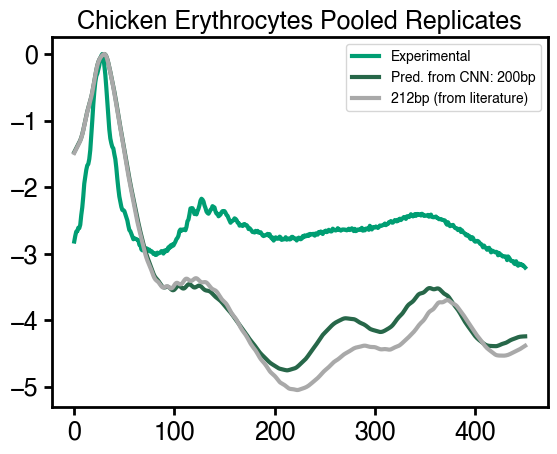

In [233]:
plt.title("Chicken Erythrocytes Pooled Replicates")
plt.plot(np.log2(all_chicken_reformat.flatten()), label = 'Experimental', color ='#009E73')
nrl = int(np.round(all_chick_preds[0][0]))
plt.plot(load_all_trials(nrl), label = 'Pred. from CNN: ' + str(nrl)+'bp', color ='#276749')
nrl = 212
plt.plot(load_all_trials(nrl), label = str(nrl)+"bp (from literature)", color = "darkgrey")

plt.legend()
plt.show()

In [234]:
# import pandas as pd
# k562_exp_all = pd.read_csv("/ru-auth/local/home/abrenner/mystore/exp_data/ricc_seq_data/k562/K562_scrm_300_bymark_FLD.csv")
# k562_exp = k562_exp_all.loc[k562_exp_all.mark=="whole_genome"].copy()
# k562_size = np.array(k562_exp.insert_size)
# min_idx = np.where(k562_size==50)[0][0]
# max_idx = np.where(k562_size==501)[0][0]
# k562_frag_len = k562_size[min_idx:max_idx]
# k562_raw_count = np.array(k562_exp.read_count)[min_idx:max_idx]

In [235]:
# # smoothed_k562 = nearest_neighbor_smooth(k562_raw_count).reshape(-1, 1)
# smoothed_k562 = k562_raw_count.reshape(-1, 1)
# k562_pre = smoothed_k562/np.max(smoothed_k562)
# k562 = k562_pre[:,:,None]
# k562_tensor = torch.tensor(k562, dtype=torch.float32)
# k562_tensor = k562_tensor.permute(1, 2, 0)

# with torch.no_grad():  # We do not need to compute gradients for predictions
#     predictions_k562= model(k562_tensor)

# predictions_k562*nrl_sim_targets_std+sim_targets_mean

tensor([[206.4887]])

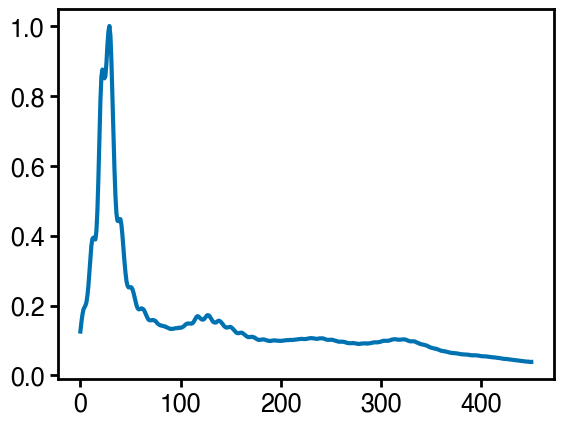

In [236]:
# plt.plot(k562_pre)

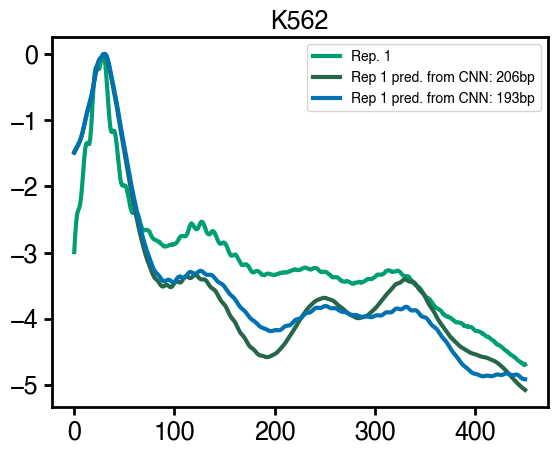

In [237]:
# plt.title("K562")
# plt.plot(np.log2(k562_pre), label = 'Rep. 1', color ='#009E73')
# # plt.plot(np.log2(chick_reformat[1]), label = 'Rep. 2', color ='#7FACD6')
# # plt.plot(np.log2(chick_reformat[2]), label = 'Rep. 3', color ='#FFAD60')
# nrl = 206
# plt.plot(load_all_trials(nrl), label = 'Rep 1 pred. from CNN: ' + str(nrl)+'bp', color ='#276749')
# nrl = 193
# plt.plot(load_all_trials(nrl), label = 'Rep 1 pred. from CNN: ' + str(nrl)+'bp')#, color ='#276749')

# # plt.xlim(300,400)
# # plt.ylim(-4,-2)
# plt.legend()
# plt.show()

# New data from Hera

In [72]:
hera_fp = '/rugpfs/fs0/risc_lab/scratch/hcanaj/H1low_biorep2_day3_day5_aligned_hg38/'
rep_1_suff = 'K562_Scr_day5_biorep2_300gy1/K562_Scr_day5_biorep2_300gy1_hist_data_withoutdups.log'
rep_2_suff = 'K562_Scr_day5_biorep2_300gy2/K562_Scr_day5_biorep2_300gy2_hist_data_withoutdups.log'

In [86]:
df1 = pd.read_csv(hera_fp + rep_1_suff, sep='\t', comment='#', skiprows=10)
experimental_data_subset1 = df1[(df1.insert_size>=50) & (df1.insert_size<=500)]
k562_rep1 = np.array(experimental_data_subset1['All_Reads.fr_count'])
k562_rep1 = k562_rep1 / np.max(k562_rep1)

df2 = pd.read_csv(hera_fp + rep_2_suff, sep='\t', comment='#', skiprows=10)
experimental_data_subset2 = df2[(df2.insert_size>=50) & (df2.insert_size<=500)]
k562_rep2 = np.array(experimental_data_subset2['All_Reads.fr_count'])
k562_rep2 = k562_rep2 / np.max(k562_rep2)

k562_rep1_reformat = k562_rep1.reshape(-1, 1)[:,:,None]
k562_rep1_tensor = torch.tensor(k562_rep1_reformat, dtype=torch.float32)
k562_rep1_tensor = k562_rep1_tensor.permute(1, 2, 0)

with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_k562_rep1= model(k562_rep1_tensor)

k562_rep1_pred = predictions_k562_rep1*nrl_sim_targets_std+sim_targets_mean
# np.array(k562_rep1_pred[0][0])

k562_rep2_reformat = k562_rep2.reshape(-1, 1)[:,:,None]
k562_rep2_tensor = torch.tensor(k562_rep2_reformat, dtype=torch.float32)
k562_rep2_tensor = k562_rep2_tensor.permute(1, 2, 0)

with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_k562_rep2 = model(k562_rep2_tensor)

predictions_k562_rep1_int = int(np.round(predictions_k562_rep1.item()*nrl_sim_targets_std+sim_targets_mean))
predictions_k562_rep2_int = int(np.round(predictions_k562_rep2.item()*nrl_sim_targets_std+sim_targets_mean))

print(predictions_k562_rep1_int)
print(predictions_k562_rep2_int)

205
210


In [82]:
w = 5
df1 = pd.read_csv(hera_fp + rep_1_suff, sep='\t', comment='#', skiprows=10)
experimental_data_subset1 = df1[(df1.insert_size>=50) & (df1.insert_size<=500)]
k562_rep1_smooth = np.array(experimental_data_subset1['All_Reads.fr_count'])
k562_rep1_smooth = nearest_neighbor_smooth(k562_rep1_smooth, halfwidth = w)
k562_rep1_smooth = k562_rep1_smooth / np.max(k562_rep1_smooth)

df2 = pd.read_csv(hera_fp + rep_2_suff, sep='\t', comment='#', skiprows=10)
experimental_data_subset2 = df2[(df2.insert_size>=50) & (df2.insert_size<=500)]
k562_rep2_smooth = np.array(experimental_data_subset2['All_Reads.fr_count'])
k562_rep2_smooth = nearest_neighbor_smooth(k562_rep2_smooth, halfwidth = w)
k562_rep2_smooth = k562_rep2_smooth / np.max(k562_rep2_smooth)

k562_rep1_smooth_reformat = k562_rep1_smooth.reshape(-1, 1)[:,:,None]
k562_rep1_smooth_tensor = torch.tensor(k562_rep1_smooth_reformat, dtype=torch.float32)
k562_rep1_smooth_tensor = k562_rep1_smooth_tensor.permute(1, 2, 0)

with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_k562_rep1_smooth= model(k562_rep1_smooth_tensor)

k562_rep1_smooth_pred = predictions_k562_rep1_smooth*nrl_sim_targets_std+sim_targets_mean
# np.array(k562_rep1_smooth_pred[0][0])

k562_rep2_smooth_reformat = k562_rep2_smooth.reshape(-1, 1)[:,:,None]
k562_rep2_smooth_tensor = torch.tensor(k562_rep2_smooth_reformat, dtype=torch.float32)
k562_rep2_smooth_tensor = k562_rep2_smooth_tensor.permute(1, 2, 0)

with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_k562_rep2_smooth = model(k562_rep2_smooth_tensor)

predictions_k562_rep1_smooth_int = int(np.round(predictions_k562_rep1_smooth.item()*nrl_sim_targets_std+sim_targets_mean))
predictions_k562_rep2_smooth_int = int(np.round(predictions_k562_rep2_smooth.item()*nrl_sim_targets_std+sim_targets_mean))

In [83]:
print(predictions_k562_rep1_smooth_int)
print(predictions_k562_rep2_smooth_int)

193
195


In [64]:
# preds1 = []
# preds2 = []
# for w in range(1,20):
#     df1 = pd.read_csv(hera_fp + rep_1_suff, sep='\t', comment='#', skiprows=10)
#     experimental_data_subset1 = df1[(df1.insert_size>=50) & (df1.insert_size<=500)]
#     k562_rep1 = np.array(experimental_data_subset1['All_Reads.fr_count'])
#     k562_rep1 = nearest_neighbor_smooth(k562_rep1, halfwidth = w)
#     k562_rep1 = k562_rep1 / np.max(k562_rep1)
    
#     df2 = pd.read_csv(hera_fp + rep_2_suff, sep='\t', comment='#', skiprows=10)
#     experimental_data_subset2 = df2[(df2.insert_size>=50) & (df2.insert_size<=500)]
#     k562_rep2 = np.array(experimental_data_subset2['All_Reads.fr_count'])
#     k562_rep2 = nearest_neighbor_smooth(k562_rep2, halfwidth = w)
#     k562_rep2 = k562_rep2 / np.max(k562_rep2)

#     k562_rep1_reformat = k562_rep1.reshape(-1, 1)[:,:,None]
#     k562_rep1_tensor = torch.tensor(k562_rep1_reformat, dtype=torch.float32)
#     k562_rep1_tensor = k562_rep1_tensor.permute(1, 2, 0)
    
#     with torch.no_grad():  # We do not need to compute gradients for predictions
#         predictions_k562_rep1= model(k562_rep1_tensor)
    
#     k562_rep1_pred = predictions_k562_rep1*nrl_sim_targets_std+sim_targets_mean
#     print("WIDTH...."+str(w))
#     print(k562_rep1_pred[0][0].item())

#     k562_rep2_reformat = k562_rep2.reshape(-1, 1)[:,:,None]
#     k562_rep2_tensor = torch.tensor(k562_rep2_reformat, dtype=torch.float32)
#     k562_rep2_tensor = k562_rep2_tensor.permute(1, 2, 0)
    
#     with torch.no_grad():  # We do not need to compute gradients for predictions
#         predictions_k562_rep2= model(k562_rep2_tensor)
    
#     k562_rep2_pred = predictions_k562_rep2*nrl_sim_targets_std+sim_targets_mean
#     print(k562_rep2_pred[0][0].item())
#     preds1.append(k562_rep1_pred[0][0].item())
#     preds2.append(k562_rep2_pred[0][0].item())

In [65]:
# plt.plot(preds1)
# plt.plot(preds2)

In [66]:
# plt.title("K562")
# plt.plot(np.log2(k562_pre), label = 'Rep. 1', color ='#009E73')
# # plt.plot(np.log2(chick_reformat[1]), label = 'Rep. 2', color ='#7FACD6')
# # plt.plot(np.log2(chick_reformat[2]), label = 'Rep. 3', color ='#FFAD60')
# nrl = 205
# plt.plot(load_all_trials(nrl), label = 'Rep 1 pred. from CNN: ' + str(nrl)+'bp', color ='#276749')
# nrl = 193
# plt.plot(load_all_trials(nrl), label = 'Rep 1 pred. from CNN: ' + str(nrl)+'bp')#, color ='#276749')

# # plt.xlim(300,400)
# # plt.ylim(-4,-2)
# plt.legend()
# plt.show()

# Try with H1 low

In [101]:
rep_1_dh1_suff = 'K562_dH1_day5_biorep2_300gy1/K562_dH1_day5_biorep2_300gy1_hist_data_withoutdups.log'
rep_2_dh1_suff = 'K562_dH1_day5_biorep2_300gy2/K562_dH1_day5_biorep2_300gy2_hist_data_withoutdups.log'
w = 5
df1 = pd.read_csv(hera_fp + rep_1_dh1_suff, sep='\t', comment='#', skiprows=10)
experimental_data_subset1 = df1[(df1.insert_size>=50) & (df1.insert_size<=500)]
k562_dh1_rep1_smooth = np.array(experimental_data_subset1['All_Reads.fr_count'])
k562_dh1_rep1_smooth = nearest_neighbor_smooth(k562_dh1_rep1_smooth, halfwidth = w)
k562_dh1_rep1_smooth = k562_dh1_rep1_smooth / np.max(k562_dh1_rep1_smooth)

df2 = pd.read_csv(hera_fp + rep_2_dh1_suff, sep='\t', comment='#', skiprows=10)
experimental_data_subset2 = df2[(df2.insert_size>=50) & (df2.insert_size<=500)]
k562_dh1_rep2_smooth = np.array(experimental_data_subset2['All_Reads.fr_count'])
k562_dh1_rep2_smooth = nearest_neighbor_smooth(k562_dh1_rep2_smooth, halfwidth = w)
k562_dh1_rep2_smooth = k562_dh1_rep2_smooth / np.max(k562_dh1_rep2_smooth)

k562_dh1_rep1_smooth_reformat = k562_dh1_rep1_smooth.reshape(-1, 1)[:,:,None]
k562_dh1_rep1_smooth_tensor = torch.tensor(k562_dh1_rep1_smooth_reformat, dtype=torch.float32)
k562_dh1_rep1_smooth_tensor = k562_dh1_rep1_smooth_tensor.permute(1, 2, 0)

with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_k562_dh1_rep1_smooth= model(k562_dh1_rep1_smooth_tensor)

k562_dh1_rep1_smooth_pred = predictions_k562_dh1_rep1_smooth*nrl_sim_targets_std+sim_targets_mean
# np.array(k562_dh1_rep1_smooth_pred[0][0])

k562_dh1_rep2_smooth_reformat = k562_dh1_rep2_smooth.reshape(-1, 1)[:,:,None]
k562_dh1_rep2_smooth_tensor = torch.tensor(k562_dh1_rep2_smooth_reformat, dtype=torch.float32)
k562_dh1_rep2_smooth_tensor = k562_dh1_rep2_smooth_tensor.permute(1, 2, 0)

with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_k562_dh1_rep2_smooth = model(k562_dh1_rep2_smooth_tensor)

predictions_k562_dh1_rep1_smooth_int = int(np.round(predictions_k562_dh1_rep1_smooth.item()*nrl_sim_targets_std+sim_targets_mean))
predictions_k562_dh1_rep2_smooth_int = int(np.round(predictions_k562_dh1_rep2_smooth.item()*nrl_sim_targets_std+sim_targets_mean))

In [105]:
predictions_k562_dh1_rep2_smooth_int

171

In [350]:
# rep_1_suff_dh1 = 'K562_dH1_day5_biorep2_300gy1/K562_dH1_day5_biorep2_300gy1_hist_data_withoutdups.log'
# rep_2_suff_dh2 = 'K562_dH1_day5_biorep2_300gy2/K562_dH1_day5_biorep2_300gy2_hist_data_withoutdups.log'
# df1 = pd.read_csv(hera_fp + rep_1_suff_dh1, sep='\t', comment='#', skiprows=10)
# df2 = pd.read_csv(hera_fp + rep_2_suff_dh2, sep='\t', comment='#', skiprows=10)
# preds1 = []
# preds2 = []
# for w in range(1,20):
    
#     experimental_data_subset1 = df1[(df1.insert_size>=50) & (df1.insert_size<=500)]
#     k562_rep1 = np.array(experimental_data_subset1['All_Reads.fr_count'])
#     k562_rep1 = nearest_neighbor_smooth(k562_rep1, halfwidth = w)
#     k562_rep1 = k562_rep1 / np.max(k562_rep1)
    
    
#     experimental_data_subset2 = df2[(df2.insert_size>=50) & (df2.insert_size<=500)]
#     k562_rep2 = np.array(experimental_data_subset2['All_Reads.fr_count'])
#     k562_rep2 = nearest_neighbor_smooth(k562_rep2, halfwidth = w)
#     k562_rep2 = k562_rep2 / np.max(k562_rep2)

#     k562_rep1_reformat = k562_rep1.reshape(-1, 1)[:,:,None]
#     k562_rep1_tensor = torch.tensor(k562_rep1_reformat, dtype=torch.float32)
#     k562_rep1_tensor = k562_rep1_tensor.permute(1, 2, 0)
    
#     with torch.no_grad():  # We do not need to compute gradients for predictions
#         predictions_k562_rep1= model(k562_rep1_tensor)
    
#     k562_rep1_pred = predictions_k562_rep1*nrl_sim_targets_std+sim_targets_mean
#     print("WIDTH...."+str(w))
#     print(k562_rep1_pred[0][0].item())

#     k562_rep2_reformat = k562_rep2.reshape(-1, 1)[:,:,None]
#     k562_rep2_tensor = torch.tensor(k562_rep2_reformat, dtype=torch.float32)
#     k562_rep2_tensor = k562_rep2_tensor.permute(1, 2, 0)
    
#     with torch.no_grad():  # We do not need to compute gradients for predictions
#         predictions_k562_rep2= model(k562_rep2_tensor)
    
#     k562_rep2_pred = predictions_k562_rep2*nrl_sim_targets_std+sim_targets_mean
#     print(k562_rep2_pred[0][0].item())
#     preds1.append(k562_rep1_pred[0][0].item())
#     preds2.append(k562_rep2_pred[0][0].item())

WIDTH....1
180.689697265625
184.24337768554688
WIDTH....2
180.1016082763672
182.56947326660156
WIDTH....3
177.4959716796875
179.10508728027344
WIDTH....4
173.86581420898438
175.0982666015625
WIDTH....5
170.68118286132812
170.81214904785156
WIDTH....6
170.7965087890625
170.4345245361328
WIDTH....7
171.09681701660156
170.51547241210938
WIDTH....8
171.1733856201172
170.69003295898438
WIDTH....9
170.65145874023438
170.4381103515625
WIDTH....10
170.48959350585938
170.2342987060547
WIDTH....11
170.51498413085938
170.18551635742188
WIDTH....12
170.75262451171875
170.367431640625
WIDTH....13
171.1099395751953
171.04034423828125
WIDTH....14
171.7015380859375
171.01878356933594
WIDTH....15
172.37823486328125
171.3773193359375
WIDTH....16
173.02940368652344
172.1023712158203
WIDTH....17
172.8938751220703
172.95220947265625
WIDTH....18
172.5933074951172
173.92221069335938
WIDTH....19
172.34915161132812
174.50515747070312


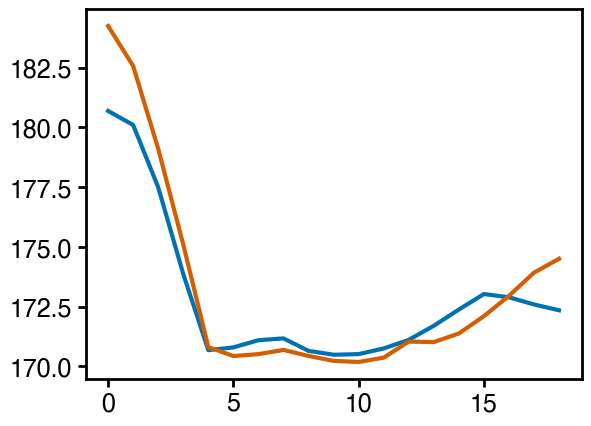

In [356]:
# plt.plot(preds1)
# plt.plot(preds2)

In [376]:
# def predict_with_uncertainty(model, input, n_iterations=1000):
#     predictions = []
#     for _ in range(n_iterations):
#         model.train()  # Enable dropout
#         output = model(input)
#         predictions.append(output.detach().numpy())
#         model.eval()  # Disable dropout for other parts of your evaluation
        
#     predictions = np.array(predictions)
#     mean_predictions = predictions.mean(axis=0)*nrl_sim_targets_std+sim_targets_mean
#     std_dev_predictions = predictions.std(axis=0)*nrl_sim_targets_std
#     return mean_predictions, std_dev_predictions

In [377]:
# # Assuming `model` is your 1D-CNN and `val_loader` is your DataLoader for the validation set
# model.eval()

# for w in range(1,20):
#     experimental_data_subset2 = df2[(df2.insert_size>=50) & (df2.insert_size<=500)]
#     k562_rep2 = np.array(experimental_data_subset2['All_Reads.fr_count'])
#     k562_rep2 = nearest_neighbor_smooth(k562_rep2, halfwidth = w)
#     k562_rep2 = k562_rep2 / np.max(k562_rep2)
    
#     k562_rep2_reformat = k562_rep2.reshape(-1, 1)[:,:,None]
#     k562_rep2_tensor = torch.tensor(k562_rep2_reformat, dtype=torch.float32)
#     k562_rep2_tensor = k562_rep2_tensor.permute(1, 2, 0)
    

    
#     # Example usage with a batch from validation set
#     mean_preds, std_preds = predict_with_uncertainty(model, k562_rep2_tensor)
    
#     print("Mean Predictions:", mean_preds)
#     print("Standard Deviations:", std_preds)

Mean Predictions: [[183.74982]]
Standard Deviations: [[2.5975113]]
Mean Predictions: [[182.3461]]
Standard Deviations: [[2.4127421]]
Mean Predictions: [[178.75911]]
Standard Deviations: [[1.7335782]]
Mean Predictions: [[174.70938]]
Standard Deviations: [[1.2066789]]
Mean Predictions: [[170.78534]]
Standard Deviations: [[0.64730865]]
Mean Predictions: [[170.41316]]
Standard Deviations: [[0.3456783]]
Mean Predictions: [[170.61961]]
Standard Deviations: [[0.39297584]]
Mean Predictions: [[170.72969]]
Standard Deviations: [[0.49219313]]
Mean Predictions: [[170.46674]]
Standard Deviations: [[0.49258682]]
Mean Predictions: [[170.37431]]
Standard Deviations: [[0.50603753]]
Mean Predictions: [[170.43279]]
Standard Deviations: [[0.52166504]]
Mean Predictions: [[170.49313]]
Standard Deviations: [[0.61649364]]
Mean Predictions: [[170.60658]]
Standard Deviations: [[0.7510267]]
Mean Predictions: [[170.37953]]
Standard Deviations: [[0.85197043]]
Mean Predictions: [[170.18532]]
Standard Deviations: [[

# Repeat for chicken

In [381]:
# all_stds = []
# for w in range(1,20):
#     nrl_chicken = nrl_chicken/np.sum(nrl_chicken, axis = 1, keepdims = True)
#     smoothed_chicken = nearest_neighbor_smooth(nrl_chicken, halfwidth = w)
#     chick_reformat = max_normalize_rows(smoothed_chicken)[:,:,None]
#     chicken_tensor = torch.tensor(chick_reformat, dtype=torch.float32)
#     chicken_tensor = chicken_tensor.permute(0, 2, 1)
    
#     # Example usage with a batch from validation set
#     mean_preds, std_preds = predict_with_uncertainty(model, chicken_tensor)
    
#     print("Mean Predictions:", mean_preds)
#     print("Standard Deviations:", std_preds)
#     all_stds.append(std_preds)

Mean Predictions: [[199.07036]
 [194.40677]
 [198.23703]]
Standard Deviations: [[1.1543931]
 [1.506244 ]
 [2.2405648]]
Mean Predictions: [[199.35985]
 [195.94992]
 [201.92363]]
Standard Deviations: [[0.95861423]
 [1.3228166 ]
 [2.2629209 ]]
Mean Predictions: [[199.055  ]
 [196.5772 ]
 [201.03479]]
Standard Deviations: [[0.8866233]
 [1.0011129]
 [2.1345487]]
Mean Predictions: [[198.29495]
 [196.08855]
 [198.28873]]
Standard Deviations: [[1.2433858]
 [1.2750796]
 [2.2257924]]
Mean Predictions: [[194.73149]
 [192.82019]
 [191.91019]]
Standard Deviations: [[1.7728252]
 [1.6639501]
 [1.8726146]]
Mean Predictions: [[191.1383 ]
 [188.25575]
 [188.30484]]
Standard Deviations: [[1.472592 ]
 [1.4432952]
 [1.4637108]]
Mean Predictions: [[191.42023]
 [188.82841]
 [189.59988]]
Standard Deviations: [[1.4303097]
 [1.4490942]
 [1.3384836]]
Mean Predictions: [[191.66762]
 [189.04416]
 [190.72987]]
Standard Deviations: [[1.4977812]
 [1.4558964]
 [1.2952477]]
Mean Predictions: [[189.61841]
 [188.92897]
 

In [67]:
# plt.scatter([i for i in range(0,len(all_stds))],[std[0] for std in all_stds], label = "Rep. 1")
# plt.scatter([i for i in range(0,len(all_stds))],[std[1] for std in all_stds], label = "Rep. 2")
# plt.scatter([i for i in range(0,len(all_stds))],[std[2] for std in all_stds], label = "Rep. 3")
# plt.legend()

# Yeast Data

In [270]:
nrl_yeast = np.squeeze(np.load(data_folder + 'yeast_data.npy', allow_pickle=True))

In [277]:
smooth_yeast = nearest_neighbor_smooth(nrl_yeast, halfwidth = 5)
nrl_yeast = smooth_yeast/np.max(smooth_yeast)
nrl_yeast_reformat_smooth = nrl_yeast.reshape(-1, 1)[:,:,None]
yeast_tensor = torch.tensor(nrl_yeast_reformat_smooth, dtype=torch.float32)
yeast_tensor = yeast_tensor.permute(1, 2, 0)

In [278]:
with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_yeast_w_smooth= model(yeast_tensor)

In [279]:
predictions_yeast_w_smooth = predictions_yeast_w_smooth*nrl_sim_targets_std+sim_targets_mean

In [280]:
predictions_yeast_w_smooth

tensor([[156.4767]])

In [281]:
nrl_yeast = np.squeeze(np.load(data_folder + 'yeast_data.npy', allow_pickle=True))
# smooth_yeast = nearest_neighbor_smooth(nrl_yeast, halfwidth = 5)
nrl_yeast = nrl_yeast/np.max(nrl_yeast)
nrl_yeast_reformat = nrl_yeast.reshape(-1, 1)[:,:,None]
yeast_tensor = torch.tensor(nrl_yeast_reformat, dtype=torch.float32)
yeast_tensor = yeast_tensor.permute(1, 2, 0)

with torch.no_grad():  # We do not need to compute gradients for predictions
    predictions_yeast= model(yeast_tensor)

In [276]:
predictions_yeast = predictions_yeast*nrl_sim_targets_std+sim_targets_mean
predictions_yeast

tensor([[158.3134]])

# Plot all data -- with and without smoothing

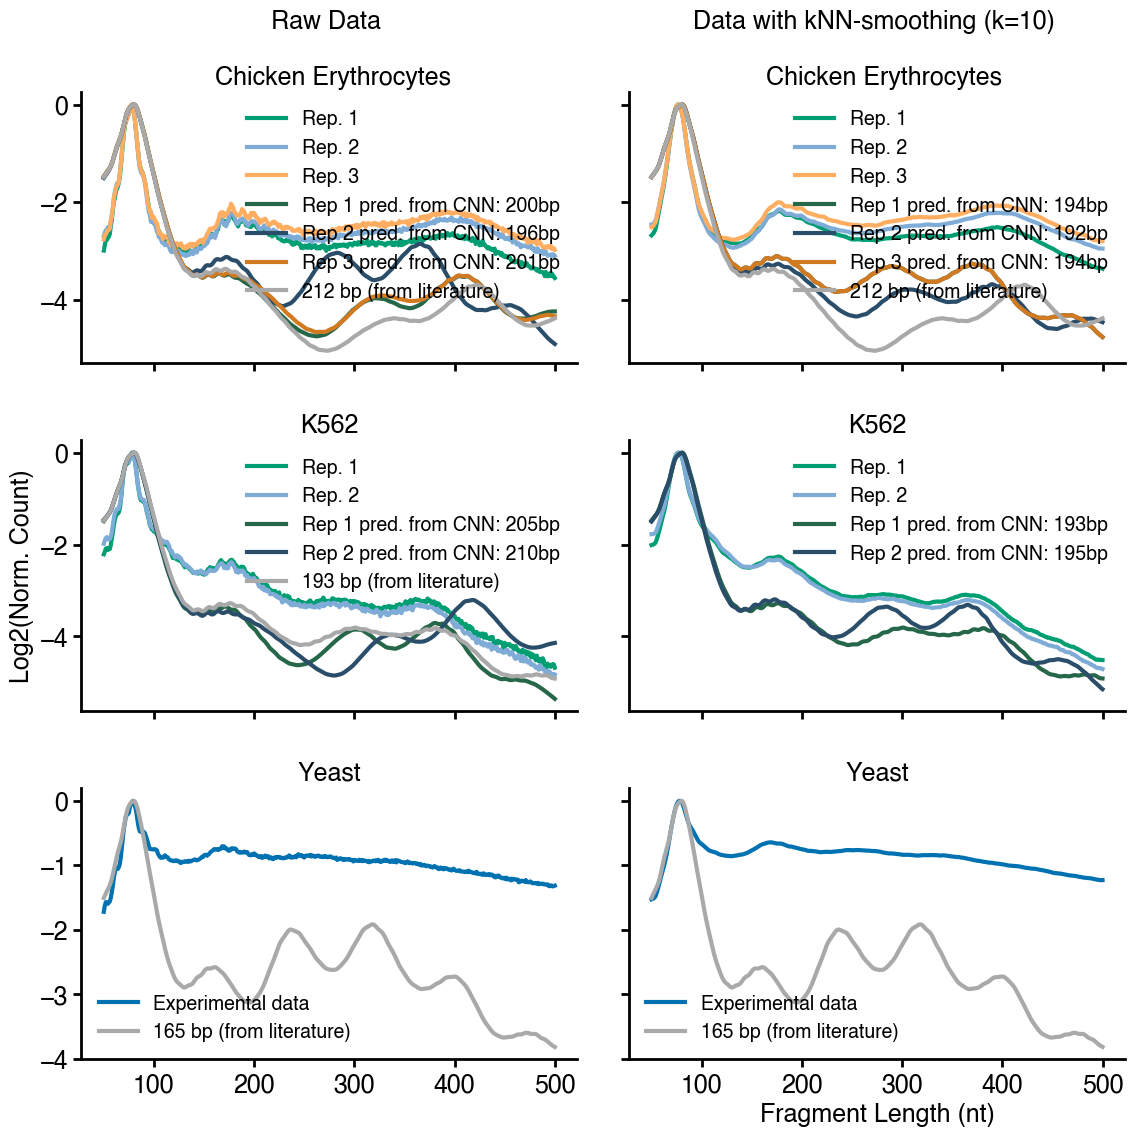

In [305]:
fix, ax = plt.subplots(3, 2, figsize = (12,12), sharey = 'row', sharex = True)
xs = np.arange(50,501)
# CHICKEN 

ax[0,0].set_title("Raw Data \n \n Chicken Erythrocytes")
ax[0,0].plot(xs, np.log2(chick_reformat[0]), label = 'Rep. 1', color ='#009E73')
ax[0,0].plot(xs, np.log2(chick_reformat[1]), label = 'Rep. 2', color ='#7FACD6')
ax[0,0].plot(xs, np.log2(chick_reformat[2]), label = 'Rep. 3', color ='#FFAD60')
nrl = int(np.round(chicken_predictions[0][0]))
ax[0,0].plot(xs, load_all_trials(nrl), label = 'Rep 1 pred. from CNN: ' + str(nrl)+'bp', color ='#276749')
nrl = int(np.round(chicken_predictions[1][0]))
ax[0,0].plot(xs, load_all_trials(nrl), label = 'Rep 2 pred. from CNN: ' + str(nrl)+'bp', color = '#2A4D69')
nrl = int(np.round(chicken_predictions[2][0]))
ax[0,0].plot(xs, load_all_trials(nrl), label = 'Rep 3 pred. from CNN: ' + str(nrl)+'bp', color = '#D17A22')
nrl = 212
ax[0,0].plot(xs, load_all_trials(nrl), label = str(nrl)+" bp (from literature)", color = "darkgrey")
ax[0,0].legend(frameon=False, fontsize = 14)

# CHICKEN SMOOTH 

ax[0,1].set_title("Data with kNN-smoothing (k=10) \n \n  Chicken Erythrocytes")
ax[0,1].plot(xs, np.log2(chick_reformat_smooth[0]), label = 'Rep. 1', color ='#009E73')
ax[0,1].plot(xs, np.log2(chick_reformat_smooth[1]), label = 'Rep. 2', color ='#7FACD6')
ax[0,1].plot(xs, np.log2(chick_reformat_smooth[2]), label = 'Rep. 3', color ='#FFAD60')
nrl = int(np.round(chicken_predictions_smooth[0][0]))
ax[0,1].plot(xs, load_all_trials(nrl), label = 'Rep 1 pred. from CNN: ' + str(nrl)+'bp', color ='#276749')
nrl = int(np.round(chicken_predictions_smooth[1][0]))
ax[0,1].plot(xs, load_all_trials(nrl), label = 'Rep 2 pred. from CNN: ' + str(nrl)+'bp', color = '#2A4D69')
nrl = int(np.round(chicken_predictions_smooth[2][0]))
ax[0,1].plot(xs, load_all_trials(nrl), label = 'Rep 3 pred. from CNN: ' + str(nrl)+'bp', color = '#D17A22')
nrl = 212
ax[0,1].plot(xs, load_all_trials(nrl), label = str(nrl)+" bp (from literature)", color = "darkgrey")
ax[0,1].legend(frameon=False, fontsize = 14)

# K562
ax[1,0].set_title("K562")
ax[1,0].plot(xs, np.log2(k562_rep1), label = 'Rep. 1', color ='#009E73')
ax[1,0].plot(xs, np.log2(k562_rep2), label = 'Rep. 2', color ='#7FACD6')
nrl = predictions_k562_rep1_int
ax[1,0].plot(xs, load_all_trials(nrl), label = 'Rep 1 pred. from CNN: ' + str(nrl)+'bp', color ='#276749')
nrl = predictions_k562_rep2_int
ax[1,0].plot(xs, load_all_trials(nrl), label = 'Rep 2 pred. from CNN: ' + str(nrl)+'bp', color = '#2A4D69')
nrl = 193
ax[1,0].plot(xs, load_all_trials(nrl), label = str(nrl)+" bp (from literature)", color = "darkgrey")
ax[1,0].legend(frameon=False, fontsize = 14)

# K562 SMOOTH

ax[1,1].set_title("K562")
ax[1,1].plot(xs, np.log2(k562_rep1_smooth), label = 'Rep. 1', color ='#009E73')
ax[1,1].plot(xs, np.log2(k562_rep2_smooth), label = 'Rep. 2', color ='#7FACD6')
nrl = predictions_k562_rep1_smooth_int
ax[1,1].plot(xs, load_all_trials(nrl), label = 'Rep 1 pred. from CNN: ' + str(nrl)+'bp', color ='#276749')
nrl = predictions_k562_rep2_smooth_int
ax[1,1].plot(xs, load_all_trials(nrl), label = 'Rep 2 pred. from CNN: ' + str(nrl)+'bp', color = '#2A4D69')
# nrl = 193
# ax[1,1].plot(xs, load_all_trials(nrl), label = str(nrl)+" bp (from literature)", color = "darkgrey")
ax[1,1].legend(frameon=False, fontsize = 14)

# Yeast 
ax[2,0].set_title("Yeast")
ax[2,0].plot(xs, np.log2(nrl_yeast_reformat.flatten()), label = 'Experimental data')
nrl = 165
ax[2,0].plot(xs, load_all_trials(nrl), label = str(nrl)+" bp (from literature)", color = "darkgrey")

# Yeast Smooth
ax[2,1].set_title("Yeast")
ax[2,1].plot(xs, np.log2(nrl_yeast_reformat_smooth.flatten()), label = 'Experimental data')
ax[2,1].plot(xs, load_all_trials(nrl), label = str(nrl)+" bp (from literature)", color = "darkgrey")

[ax[2,k].legend(frameon=False, fontsize = 14) for k in range(0,2)]

ax[1,0].set_ylabel('Log2(Norm. Count)')
plt.xlabel('Fragment Length (nt)')


[ax[idx,k].spines[desc].set_visible(False) for idx in range(0,3) for k in range(0,2) for desc in ['top', 'right']]

plt.tight_layout(pad = 3)
plt.savefig(plots_dir + 'ricc_seq/ricc_all_organisms.pdf')

plt.show()

# Plot K562 Low and High

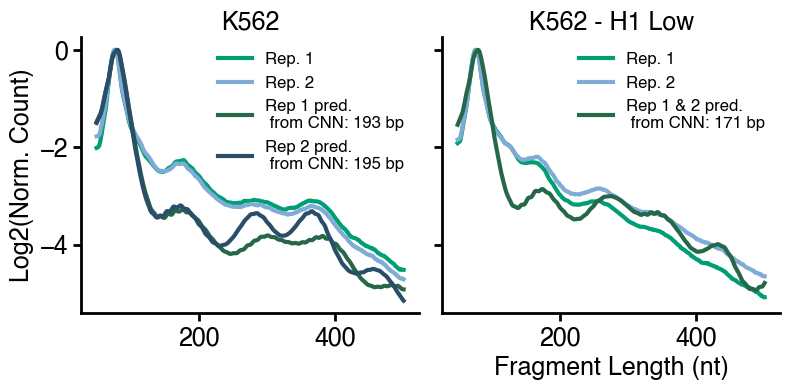

In [150]:
fig, ax = plt.subplots(1, 2, figsize = (8,4), sharey = True, sharex = True)

# K562 WT

ax[0].set_title("K562")
ax[0].plot(xs, np.log2(k562_rep1_smooth), label = 'Rep. 1', color ='#009E73')
ax[0].plot(xs, np.log2(k562_rep2_smooth), label = 'Rep. 2', color ='#7FACD6')
nrl = predictions_k562_rep1_smooth_int
ax[0].plot(xs, load_all_trials(nrl), label = 'Rep 1 pred. \n from CNN: ' + str(nrl)+' bp', color ='#276749')
nrl = predictions_k562_rep2_smooth_int
ax[0].plot(xs, load_all_trials(nrl), label = 'Rep 2 pred. \n from CNN: ' + str(nrl)+' bp', color = '#2A4D69')
# nrl = 193
# ax[1,1].plot(xs, load_all_trials(nrl), label = str(nrl)+" bp (from literature)", color = "darkgrey")
ax[0].legend(frameon=False, fontsize = 12)

ax[1].set_title("K562 - H1 Low")
ax[1].plot(xs, np.log2(k562_dh1_rep1_smooth), label = 'Rep. 1', color ='#009E73')
ax[1].plot(xs, np.log2(k562_dh1_rep2_smooth), label = 'Rep. 2', color ='#7FACD6')
nrl = predictions_k562_dh1_rep1_smooth_int
ax[1].plot(xs, load_all_trials(nrl), label = 'Rep 1 & 2 pred. \n from CNN: ' + str(nrl)+' bp', color ='#276749')
# nrl = 172
# ax[1].plot(xs, load_all_trials(nrl), label = str(nrl)+" bp (from literature)", color = "darkgrey")
ax[1].legend(frameon=False, fontsize = 12)

ax[0].set_ylabel('Log2(Norm. Count)')
plt.xlabel('Fragment Length (nt)')
[ax[idx].spines[desc].set_visible(False) for idx in range(0,2) for desc in ['top', 'right']]
plt.tight_layout()
plt.savefig(plots_dir + 'ricc_seq/ricc_h1low_vs_wt.pdf')

plt.show()

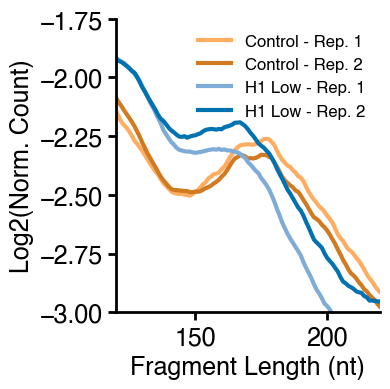

In [219]:
fig, ax = plt.subplots(1, 1, figsize = (4,4), sharey = True, sharex = True)

ax.plot(xs, np.log2(k562_rep1_smooth), label = 'Control - Rep. 1', color ='#FFAD60')
ax.plot(xs, np.log2(k562_rep2_smooth), label = 'Control - Rep. 2', color ='#D17A22')

# nrl = 193
# ax[1,1].plot(load_all_trials(nrl), label = str(nrl)+" bp (from literature)", color = "darkgrey")
ax.plot(xs, np.log2(k562_dh1_rep1_smooth), label = 'H1 Low - Rep. 1', color ='#7FACD6')#, color ='#009E73')
ax.plot(xs, np.log2(k562_dh1_rep2_smooth), label = 'H1 Low - Rep. 2')

# ax.set_ylabel('Log2(Norm. Count)')
# plt.xlabel('Fragment Length (nt)')
ax.set_xlabel('Fragment Length (nt)')
ax.set_ylabel('Log2(Norm. Count)')
ax.legend(frameon=False, fontsize = 12)
ax.set_xlim((120, 220))
ax.set_ylim((-3,-1.75))
[ax.spines[desc].set_visible(False) for desc in ['top', 'right']]
plt.tight_layout()
plt.savefig(plots_dir + 'ricc_seq/ricc_h1low_vs_wt_2ndpeak.pdf')

plt.show()

In [223]:
# Define the 1D CNN model
kernel_sz = 10
dil_sz = 5
class CNN1DRegression_cropped(nn.Module):
    def __init__(self):
        super(CNN1DRegression_cropped, self).__init__()
        # In_channels = 1 makes this a 1D CNN
        neurons = 64
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=neurons, kernel_size=kernel_sz, dilation = dil_sz, stride=1, padding=1)
        self.dropout = nn.Dropout(p=0.2)
        # self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=neurons, out_channels=2*neurons, kernel_size=kernel_sz, dilation = dil_sz, stride=1, padding=1)
        self.fc1 = nn.Linear(2432, 128)  # Adjust 1st dim  size according to your pooling and conv layers
        self.fc2 = nn.Linear(128, 1) # Predicting one output

    def forward(self, x):
        x = self.pool(torch.nn.functional.leaky_relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.nn.functional.leaky_relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [203]:
wrap_model = torch.load(model_path+'model_wrap_only_ablated.pth')

In [204]:
# Ablation range
min_ = 70
max_ = 170

In [264]:
wrap_model.eval()

with torch.no_grad():  # We do not need to compute gradients for abl_predictions
    wt_rep1 = wrap_model(k562_rep1_smooth_tensor[:,:,min_:max_])
    wt_rep2 = wrap_model(k562_rep2_smooth_tensor[:,:,min_:max_])
    dh1_rep1 = wrap_model(k562_dh1_rep1_smooth_tensor[:,:,min_:max_])
    dh1_rep2 = wrap_model(k562_dh1_rep2_smooth_tensor[:,:,min_:max_])

In [265]:
# Manually taken from source doc
wrap_mean = 132.0
wrap_std = 9.219544457292887

In [266]:
wt_rep1.item()*wrap_std + wrap_mean

135.9982633301122

In [267]:
wt_rep2.item()*wrap_std + wrap_mean

136.31135314951393

In [268]:
dh1_rep1.item()*wrap_std + wrap_mean

141.3451225209824

In [269]:
dh1_rep2.item()*wrap_std + wrap_mean

140.94735131156028

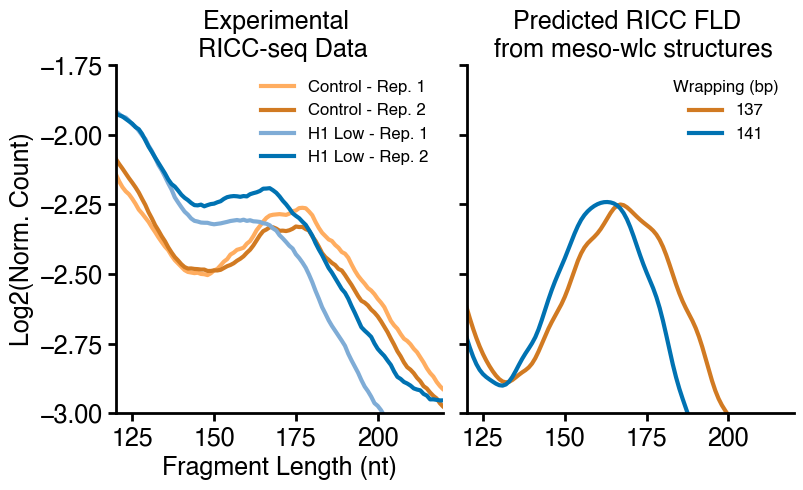

In [263]:
fig, ax = plt.subplots(1, 2, figsize = (8,5), sharey = True, sharex = True)

ax[0].plot(xs, np.log2(k562_rep1_smooth), label = 'Control - Rep. 1', color ='#FFAD60')
ax[0].plot(xs, np.log2(k562_rep2_smooth), label = 'Control - Rep. 2', color ='#D17A22')

# nrl = 193
# ax[1,1].plot(load_all_trials(nrl), label = str(nrl)+" bp (from literature)", color = "darkgrey")
ax[0].plot(xs, np.log2(k562_dh1_rep1_smooth), label = 'H1 Low - Rep. 1', color ='#7FACD6')#, color ='#009E73')
ax[0].plot(xs, np.log2(k562_dh1_rep2_smooth), label = 'H1 Low - Rep. 2')

# ax[0].set_ylabel('Log2(Norm. Count)')
# plt.xlabel('Fragment Length (nt)')
ax[0].set_xlabel('Fragment Length (nt)')
ax[0].set_ylabel('Log2(Norm. Count)')
ax[0].legend(frameon=False, fontsize = 12)
ax[0].set_xlim((120, 220))
ax[0].set_ylim((-3,-1.75))

# Plot meso 
color_list = ['#D17A22','#0072B2']
for idx, wrap in enumerate(np.array([137, 141])): # Plot every 14th NRL
    fld = np.load(data_and_figs_dir + 'flds_mean_tot_185_nrl_'+str(wrap)+'wrap_2kbt.npy')
    fld_to_plot = np.log2(fld/np.max(fld))
    ax[1].plot(np.arange(50,501), fld_to_plot, label = wrap, color = color_list[idx])
    ax[1].set_xlim((min_adj,max_adj))
    ax[1].legend(title = 'Wrapping (bp)', frameon=False, fontsize = 12, title_fontsize= 12)

[ax[k].spines[desc].set_visible(False) for desc in ['top', 'right'] for k in range(0,2)]
ax[0].set_title("Experimental \n RICC-seq Data")
ax[1].set_title("Predicted RICC FLD \n from meso-wlc structures")
plt.tight_layout()
plt.savefig(plots_dir + 'ricc_seq/ricc_h1low_vs_wt_2ndpeak_w_meso.pdf')

plt.show()